### **LAB 2B**: Simulation Prep


The thermistor is also a nonlinear resistive sensor. The purpose of this section will be to show
the techniques of linearization and signal processing. In full disclosure, we could simply use a
half-bridge for the thermistor (and you might do this for your final project). So, know a priori
this signal processing for this section is inherently overkill.


-----

#### **Deliverable 5**: Resolution Simulation

The next section is to show the correlation between resolution and signal processing. The key is
this, your microcontroller has a FIXED voltage range input on the ADC. If we select a SMALL
range in the environment to measure (i.e. 21-23 degrees F) we can amplify the input signal to
span over the entire range of the ADC. When the calculations are finished, you will have high
resolution in the measurement. Conversely, if we chose to measure a LARGE range in the
environment (i.e. the full range of the thermistor) we would likely need to use signal processing
to condense the sensor’s response to fit the range of the ADC. We would have far less resolution.


Code is awesome – it allows us to see this with just a few equations! Before battling the math,
remember that how much resolution depends on the application, but in general more is better.

Here is the upcoming path, keep writing your code such that you can change values easily. Don’t
hard code numbers, use variables. Recall that a transfer function is a mathematical relationship
relating OUT/¿ = f(x). You will want to read through this all the way before attempting to code.

In [1877]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [1878]:
### ALTERABLE VALUES ###

# Thermistor parameters
B = 3636
Ro = 1000 #ohm
To = 25 #deg C
To = To+273 #deg K

# 3-Point Model
lower_range = 15
upper_range = 30

# Wheatstone Bridge
Vcc = 5 # Supply voltage (Arduino 5V)
Rnull = 1226 #ohm, from slides for ~20deg. C room temp

# Op-amp
gain = 100

# ADC 
bias = 2.5 #V

# Calibration
AD590_temp = 19.44 #deg F


In [1879]:
# Loading in thermistor datasheet values

temps = []
for i in range(-50,160,10):
    temps.append(i)

    if i == 20:
        temps.append(25) # this is an outlier in the pattern due to being nominal R

temps_K = []
for temp in temps:
    temps_K.append(temp+273)

ohms = [44130, 23980, 13520, 7891, 4754, 2949, 1879, 1226, 1000, 819.4, 
        559.2, 389.3, 276, 199, 145.8, 108.4, 81.68, 62.35, 48.18, 37.64,
        29.72, 23.7]

data = { "Temperature":temps , "Ohms":ohms }
df = pd.DataFrame(data=data)

x = df['Temperature']
y = df['Ohms']

df

,Temperature,Ohms
0,-50,44130.00
1,-40,23980.00
2,-30,13520.00
3,-20,7891.00
4,-10,4754.00
5,0,2949.00
6,10,1879.00
7,20,1226.00
8,25,1000.00
9,30,819.40


#### Beta Model

R(T) = Ro*e^( Beta( 1/T - 1/To ))

In [1880]:
model_ohms = []
for temp in temps_K:

    resistance = Ro*(math.e**(B*((1/temp) - (1/To))))
    model_ohms.append(resistance)

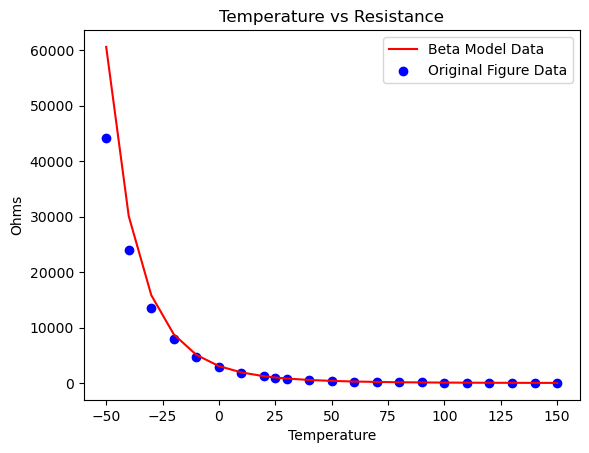

In [1881]:
### BETA MODEL PLOT ###

plt.plot(x, model_ohms, c='r', ls='-', label='Beta Model Data') # beta
plt.scatter(x, y, c='b', label='Original Figure Data') # original data

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Temperature vs Resistance')

plt.legend()
plt.show()

#### 3-Point Model

T1 - T2  =  T2 - T3

Rp1-Rp2 = Rp2-Rp3

R = [RT2*(RT1+RT3) - 2* RT1 * RT3] / (RT1 + RT3 - 2*RT2)

In [1882]:
mid_range = lower_range + (upper_range-lower_range)/2

three_temps = [lower_range, mid_range, upper_range]
three_temps

[15, 22.5, 30]

In [1883]:
# Find nearest values in temps (for when range input does not math df)
np_temps = np.array(temps)

nearest_temps = []
for temp in three_temps:
    nearest_index = np.abs(np_temps - temp).argmin()
    nearest_temps.append(np_temps[nearest_index])

three_temps = nearest_temps

In [1884]:
three_temps_K = []
three_R = []
indicies = []

for i, temp in enumerate(three_temps):
    place = temps.index(temp)

    three_R.append(model_ohms[place])
    three_temps_K.append(temps_K[place])
    indicies.append(place)

In [1885]:
temp_range = [three_temps[1]]        # this will hold the determined range of temps (starting with 20deg. C)
R_range = [three_R[1]]             # this holds the resistances corresponding to the temperatures
indicies = [temps.index(three_temps[1])]            # this holds the indicies for these matched T & R pairs (for plotting og data)

# starting indicies for the loop
start_place_up = indicies[0]
start_place_down = indicies[0]

for i in range(len(temps)-1):    # looping through until the entire range of temps has been traversed
                                 # one number is subtracted to account for the starting point temp (20deg. C)
                                 # (although it most definetly will turn negative before then)

    if i>3:
        index1 = R_range[0]
        index2 = R_range[len(R_range)//2]
        index3 = R_range[-1]

        R_solve = ( index2*(index1+index3) - 2*index1*index3 ) / ( index1+index3-(2*index2) )

        if R_solve <= 0:
            print(f"R: {R_solve}, breaking loop...")
            break
        else:
            R = R_solve
            print(f"R: {R}")

    # alternating adding indicies from above and below with odd/even:

    if (i % 2) == 0: # even
        start_place_up += 1
        temp_range.append(temps[start_place_up])
        R_range.append(model_ohms[start_place_up])
        indicies.append(start_place_up)
    
    else: # odd
        start_place_down -= 1
        temp_range.append(temps[start_place_down])
        R_range.append(model_ohms[start_place_down])
        indicies.append(start_place_down)

temp_range.sort() # put into numerical order
R_range.sort(reverse=True) # non-linear, but should still decrease with temp (inverse log)
indicies.sort()

temp_range, R_range, indicies

R: 1402.5047392624642
R: 586.6276574074739
R: -1571.9464533190965, breaking loop...


([-10, 0, 10, 20, 25, 30, 40],
 [5072.089055059766,
  3056.709580128255,
  1909.2571796276936,
  1231.4767169090992,
  1000.0,
  817.6325228563411,
  557.2569341095782],
 [4, 5, 6, 7, 8, 9, 10])

In [1886]:
from scipy.stats import linregress

# Create a numpy temperature range for the entire thermistor data
np_temp_range = np.linspace(-50, 150, 1000)  #deg. C

# getting slope & intercept by fitting line parameters to the three points 
# (using a linear regression function to save the effort)
slope, intercept, _, _, _ = linregress(three_temps, three_R) 

R_range_plot = intercept + (slope * np_temp_range) # new R points to plot

R_range_plot_list = []
for i in range(len(R_range)):
    R_range_plot_list.append(intercept + (slope*temp_range[i])) # new R points to plot

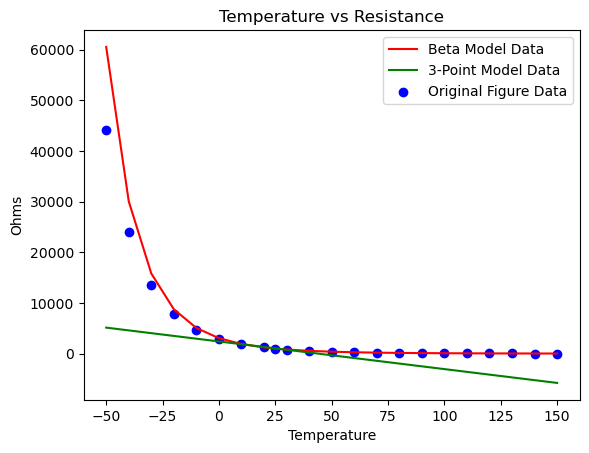

In [1887]:
### 3-POINT/BETA MODEL PLOT ###

plt.plot(x, model_ohms, c='r', ls='-', label='Beta Model Data') # beta
plt.plot(np_temp_range, R_range_plot, c='g', ls='-', label='3-Point Model Data') # 3pt
plt.scatter(x, y, c='b', label='Original Figure Data') # original data

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Temperature vs Resistance')

plt.legend()
plt.show()

#### Wheatstone Bridge

Vout = ( Rs/(Rs+R3) - R2/(R2+R1) )*Vin

Vout = ( Vcc/2 )(R-Rnull / R+Rnull)

In [1888]:
V_out = []
for i, val in enumerate(model_ohms):
    V_out.append((Vcc/2)*((val-Rnull)/(val+Rnull)))

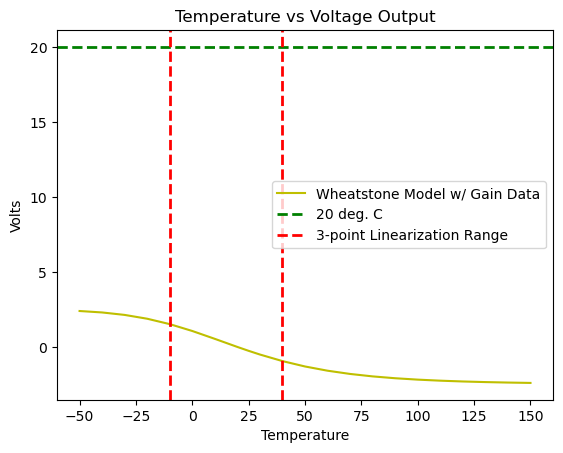

In [1889]:
### WHEATSTONE PLOT ###

plt.plot(x, V_out, c='y', ls='-', label='Wheatstone Model w/ Gain Data') # wheatstone
plt.axhline(three_temps[1], color='green', linestyle='--', linewidth=2, label=f'{three_temps[1]} deg. C')
plt.axvline(temp_range[0], color='red', linestyle='--', linewidth=2, label=f"3-point Linearization Range")
plt.axvline(temp_range[-1], color='red', linestyle='--', linewidth=2)

plt.xlabel('Temperature')
plt.ylabel('Volts')
plt.title('Temperature vs Voltage Output')

plt.legend()
plt.show()

#### Instrumentation Amplifier

Applies gain to Vout

In [1890]:
V_amp = []
for i, v in enumerate(V_out):
    V_amp.append(v*gain)

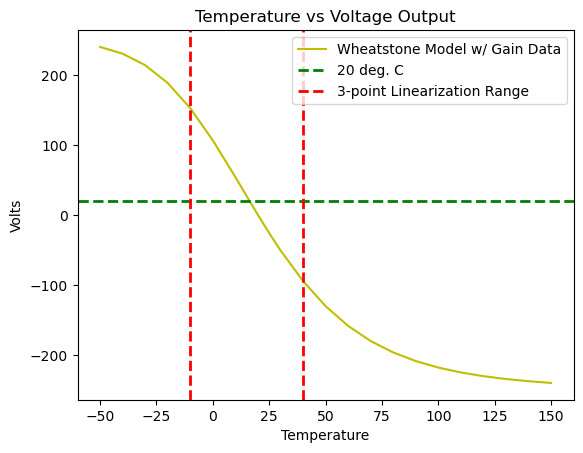

In [1891]:
### WHEATSTONE PLOT ###

plt.plot(x, V_amp, c='y', ls='-', label='Wheatstone Model w/ Gain Data') # wheatstone
plt.axhline(three_temps[1], color='green', linestyle='--', linewidth=2, label=f'{three_temps[1]} deg. C')
plt.axvline(temp_range[0], color='red', linestyle='--', linewidth=2, label=f"3-point Linearization Range")
plt.axvline(temp_range[-1], color='red', linestyle='--', linewidth=2)

plt.xlabel('Temperature')
plt.ylabel('Volts')
plt.title('Temperature vs Voltage Output')

plt.legend()
plt.show()

#### ADC Simulation

In [1892]:
V_bias = []
for v in V_out:
    V_bias.append(v+bias)

for i, v in enumerate(V_bias):
    print(f"{V_out[i]} -> {v} V")

2.4007822919682105 -> 4.900782291968211 V
2.3041809998034344 -> 4.804180999803434 V
2.140500207763481 -> 4.6405002077634805 V
1.8861423820234888 -> 4.386142382023489 V
1.526688897789517 -> 4.026688897789517 V
1.0686631593131692 -> 3.5686631593131692 V
0.5448174906251465 -> 3.0448174906251464 V
0.005571484026090343 -> 2.5055714840260905 V
-0.25381850853548965 -> 2.2461814914645104 V
-0.4995607974726451 -> 2.000439202527355 V
-0.9375304437331977 -> 1.5624695562668023 V
-1.2958488429334323 -> 1.2041511570665677 V
-1.5775212461520982 -> 0.9224787538479018 V
-1.7934888984603623 -> 0.7065111015396377 V
-1.9568518594622808 -> 0.5431481405377192 V
-2.0797578045787484 -> 0.42024219542125163 V
-2.1722392598683142 -> 0.32776074013168577 V
-2.242090972458852 -> 0.2579090275411482 V
-2.2951713061131125 -> 0.20482869388688751 V
-2.3358079331825836 -> 0.16419206681741638 V
-2.367173517490155 -> 0.13282648250984508 V
-2.3915902217937592 -> 0.10840977820624076 V


In [1893]:
ADC_values = []
for v in V_bias:
    ADC_values.append(np.round((np.array(v) / Vcc) * 1023).astype(int))

for i, v in enumerate(V_bias):
    print(f"{v} -> {ADC_values[i]} V")

# must clip to linear range
min_i = temps.index(temp_range[0])
max_i = temps.index(temp_range[-1])
ADC_values_clip = ADC_values[min_i:max_i+1]

4.900782291968211 -> 1003 V
4.804180999803434 -> 983 V
4.6405002077634805 -> 949 V
4.386142382023489 -> 897 V
4.026688897789517 -> 824 V
3.5686631593131692 -> 730 V
3.0448174906251464 -> 623 V
2.5055714840260905 -> 513 V
2.2461814914645104 -> 460 V
2.000439202527355 -> 409 V
1.5624695562668023 -> 320 V
1.2041511570665677 -> 246 V
0.9224787538479018 -> 189 V
0.7065111015396377 -> 145 V
0.5431481405377192 -> 111 V
0.42024219542125163 -> 86 V
0.32776074013168577 -> 67 V
0.2579090275411482 -> 53 V
0.20482869388688751 -> 42 V
0.16419206681741638 -> 34 V
0.13282648250984508 -> 27 V
0.10840977820624076 -> 22 V


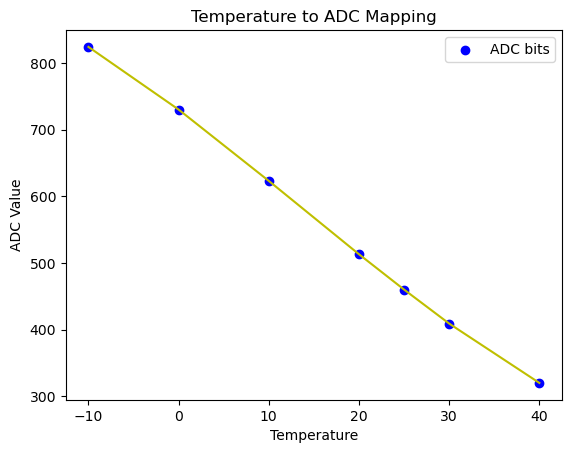

In [1894]:
### ADC MAPPING PLOT ###

plt.plot(temp_range, ADC_values_clip, c='y', ls='-')
plt.scatter(temp_range, ADC_values_clip, c='b', label=f"ADC bits")

plt.xlabel('Temperature')
plt.ylabel('ADC Value')
plt.title('Temperature to ADC Mapping')

plt.legend()
plt.show()

In [1895]:
### INVERSE OPERATIONS ###
inverse_temps = []
for adc in ADC_values:

    # removing mods from V
    voltage = (adc/1023)*Vcc 
    voltage = voltage - bias

    # Wheatstone solving for Rsense
    R = Rnull * (2*voltage + Vcc) / (Vcc - 2*voltage)

    # Beta solving for T
    log = R / (Ro * math.e**((-B)/To))
    temp = (B / (math.log(log)))
    temp = temp - 273

    inverse_temps.append(temp)

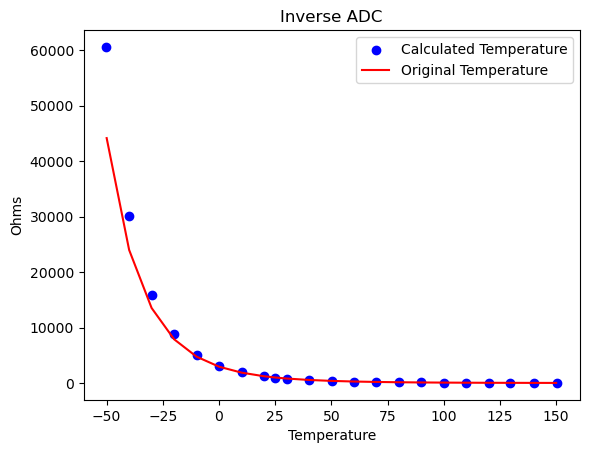

,ADC,Inverse Temp,Original Temp
0,1003,-50.207488,-50
1,983,-40.025060,-40
2,949,-29.894066,-30
3,897,-19.935404,-20
4,824,-10.016545,-10
5,730,0.014560,0
6,623,9.997257,10
7,513,19.966761,20
8,460,24.958395,25
9,409,30.029814,30


In [1896]:
# Plot the results
plt.scatter(inverse_temps, model_ohms, c='b', label='Calculated Temperature')
plt.plot(x, y, 'r', label='Original Temperature')

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Inverse ADC')
plt.legend()
plt.show()

data = { "ADC":ADC_values , "Inverse Temp":inverse_temps, "Original Temp":temps }
df = pd.DataFrame(data=data)

df

#### Calibration

In [1897]:
# Calculate calibration offset using AD590 as reference
avg_temp = three_temps[1]
calibration_offset = AD590_temp - avg_temp

# Apply calibration offset
calibrated_temps = [temp + calibration_offset for temp in inverse_temps]

for i, temp in enumerate(calibrated_temps):
    print(f"{ADC_values[i]} -> {inverse_temps[i]} -> {temp}deg. C")


1003 -> -50.207488231006664 -> -50.767488231006666deg. C
983 -> -40.02505999199059 -> -40.58505999199059deg. C
949 -> -29.89406614979177 -> -30.454066149791768deg. C
897 -> -19.93540365045314 -> -20.495403650453138deg. C
824 -> -10.016544875310103 -> -10.576544875310102deg. C
730 -> 0.014559638685113896 -> -0.5454403613148848deg. C
623 -> 9.997256516442292 -> 9.437256516442293deg. C
513 -> 19.966761488162774 -> 19.406761488162775deg. C
460 -> 24.958395448126055 -> 24.398395448126056deg. C
409 -> 30.02981441432837 -> 29.469814414328372deg. C
320 -> 39.960941087334106 -> 39.400941087334104deg. C
246 -> 50.05669764978012 -> 49.49669764978012deg. C
189 -> 59.948350902904906 -> 59.388350902904904deg. C
145 -> 69.8834526333253 -> 69.3234526333253deg. C
111 -> 80.04435059329779 -> 79.48435059329779deg. C
86 -> 89.99151248501335 -> 89.43151248501334deg. C
67 -> 100.03656322611016 -> 99.47656322611016deg. C
53 -> 109.81360786118336 -> 109.25360786118335deg. C
42 -> 119.902840044593 -> 119.34284

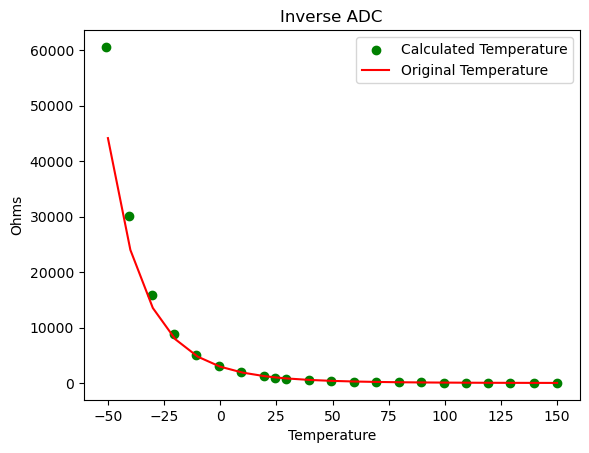

,Inverse Temp,Calibrated Temp,Original Temp
0,-50.207488,-50.767488,-50
1,-40.025060,-40.585060,-40
2,-29.894066,-30.454066,-30
3,-19.935404,-20.495404,-20
4,-10.016545,-10.576545,-10
5,0.014560,-0.545440,0
6,9.997257,9.437257,10
7,19.966761,19.406761,20
8,24.958395,24.398395,25
9,30.029814,29.469814,30


In [1898]:
# Plot the results
plt.scatter(calibrated_temps, model_ohms, c='g', label='Calculated Temperature')
plt.plot(x, y, 'r', label='Original Temperature')

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Inverse ADC')
plt.legend()
plt.show()

data = {"Inverse Temp":inverse_temps, "Calibrated Temp":calibrated_temps, "Original Temp":temps }
df = pd.DataFrame(data=data)

df